# NTSB demo

Sycamore is a **Document Processing System** = **ETL** + **Query Planning/Retrieval**.

https://aryn-public.s3.amazonaws.com/ntsb/22.pdf

**ETL steps**:
- extract Text + Structure: titles, section headers, text paragraphs, figures, tables and their cells, captions, page headers and footers, footnotes
- summarize images
- extract data from tables
- standardize locations and dates

**Query Planning/Retrieval**:
Having these structural elements and information extracted enables the consumer of these document to have much better control over what is being embedded and how, leading to better retrieval in a RAG system.
For example, we can focus the retrieval on certain sections or eliminate them altogether.

**Question answering**:
Sycamore can also extract information from a document. We’ll see how it can extract location and dates from NTSB docs, but also specific elements like aircraft type.  

Once the data is transformed, we can ask questions on it.

In [27]:
import sycamore 
from sycamore.transforms.partition import ArynPartitioner
from sycamore.transforms.summarize_images import SummarizeImages
from sycamore.transforms import (AssignDocProperties, 
                                ExtractTableProperties, 
                                StandardizeProperty, 
                                LocationStandardizer,
                                DateTimeStandardizer)

from sycamore.llms import OpenAI 
from sycamore.utils.aryn_config import ArynConfig, _DEFAULT_PATH
from sycamore.utils.pdf_utils import show_pages, enumerate_images_and_tables, display_page_and_table_properties
from sycamore.materialize import MaterializeSourceMode  

from pathlib import Path
import json

### Get Aryn Partitioner API key

In [28]:
assert ArynConfig.get_aryn_api_key() != "", f"Unable to find aryn API key.  Looked in {_DEFAULT_PATH}"

### Initialize Sycamore

In [29]:
ctx = sycamore.init()

## Load the data

We're loading NTSB incident reports from a public s3 bucket (pdf documents describing aviation incidents).

https://aryn-public.s3.amazonaws.com/ntsb/22.pdf

The documents consist of a combination of tables, text, and figures.

In [33]:
s3_path = "s3://aryn-public/ntsb/22.pdf"
llm = OpenAI('gpt-4o-mini')

# path to store cached files
materialize_dir = Path.cwd() / ".temp_cache"

## Define a pipeline using SycamorePartitioner

### Chunk and extract document structure

**ETL steps**:
- extract Text + Structure: titles, section headers, text paragraphs, figures, tables and their cells, captions, page headers and footers, footnotes
- summarize images

In [34]:
# Create a docset from segmented PDFs, extract tables, summarize images

docset = (
    ctx.read.binary(s3_path, binary_format="pdf")

    # Partition and extract tables and images
    .partition(ArynPartitioner(
                               extract_table_structure=True,
                               use_ocr=True, 
                               extract_images=True)
              )
    # Summarize each image element
    .transform(SummarizeImages)

    #Materialize document
    .materialize(
        path=f"{materialize_dir}/docset_summarized",
        source_mode=MaterializeSourceMode.IF_PRESENT)
)

## Visualize partitioned documents

### Visualize partitioned pages

In [35]:
enumerate_images_and_tables(docset.take_all())

2024-08-26 05:05:26,472	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-08-26 05:05:26,479	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-23_18-41-10_588373_17896/logs/ray-data
2024-08-26 05:05:26,480	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> ActorPoolMapOperator[Map(BinaryScan._to_document)->MapBatches(BaseMapTransformCallable___wrap)] -> TaskPoolMapOperator[MapBatches(summarize_all_images)->MapBatches(materialize)]


- ReadBinary->SplitBlocks(8) 1:   0%|                                                                         …

- Map(BinaryScan._to_document)->MapBatches(BaseMapTransformCallable___wrap) 2:   0%|                          …

- MapBatches(summarize_all_images)->MapBatches(materialize) 3:   0%|                                          …

Running 0:   0%|                                                                                              …

Path:  s3://aryn-public/ntsb/22.pdf
Image summary:  {'is_graph': False, 'summary': 'The image is a banner from the National Transportation Safety Board (NTSB) featuring icons and labels for different modes of transportation: aviation, highway, marine, railroad, and pipeline. It includes the NTSB emblem and a background with images representing each transportation mode. The image serves as a visual representation of the various areas of focus for the NTSB.'} 






Image summary:  {'is_graph': False, 'summary': 'The image is a satellite view of a large urban area with a yellow line drawn over it. The line appears to trace a specific route or path through the city and its surrounding areas. The image shows various geographical features, including roads, buildings, and green spaces. The scale at the bottom left indicates a distance of 9.60 miles.'} 




Investigator In Charge (IIC):,Sauer; Aaron
Additional Participating Persons:,"Christopher Johnson; FAA; Indianapolis, IN Brad Miller; Cirrus Aircraft; Duluth; MN"
Original Publish Date:,"April 27,2023"
Investigation Class:,Class 4
Note:,The NTSB did not travel to the scene of this accident
Investigation Docket:,https [Idata ntsbgov[Docket?ProjectIDz106630


2024-08-26 05:05:41,463	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-23_18-41-10_588373_17896/logs/ray-data
2024-08-26 05:05:41,463	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)->MapBatches(split_and_convert_to_image)] -> LimitOperator[limit=2] -> TaskPoolMapOperator[MapBatches(DrawBoxes)]


- ReadBinary->SplitBlocks(3) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document)->MapBatches(split_and_convert_to_image) 2:   0%|                          …

- limit=2 3:   0%|                                                                                            …

- MapBatches(DrawBoxes) 4:   0%|                                                                              …

Running 0:   0%|                                                                                              …

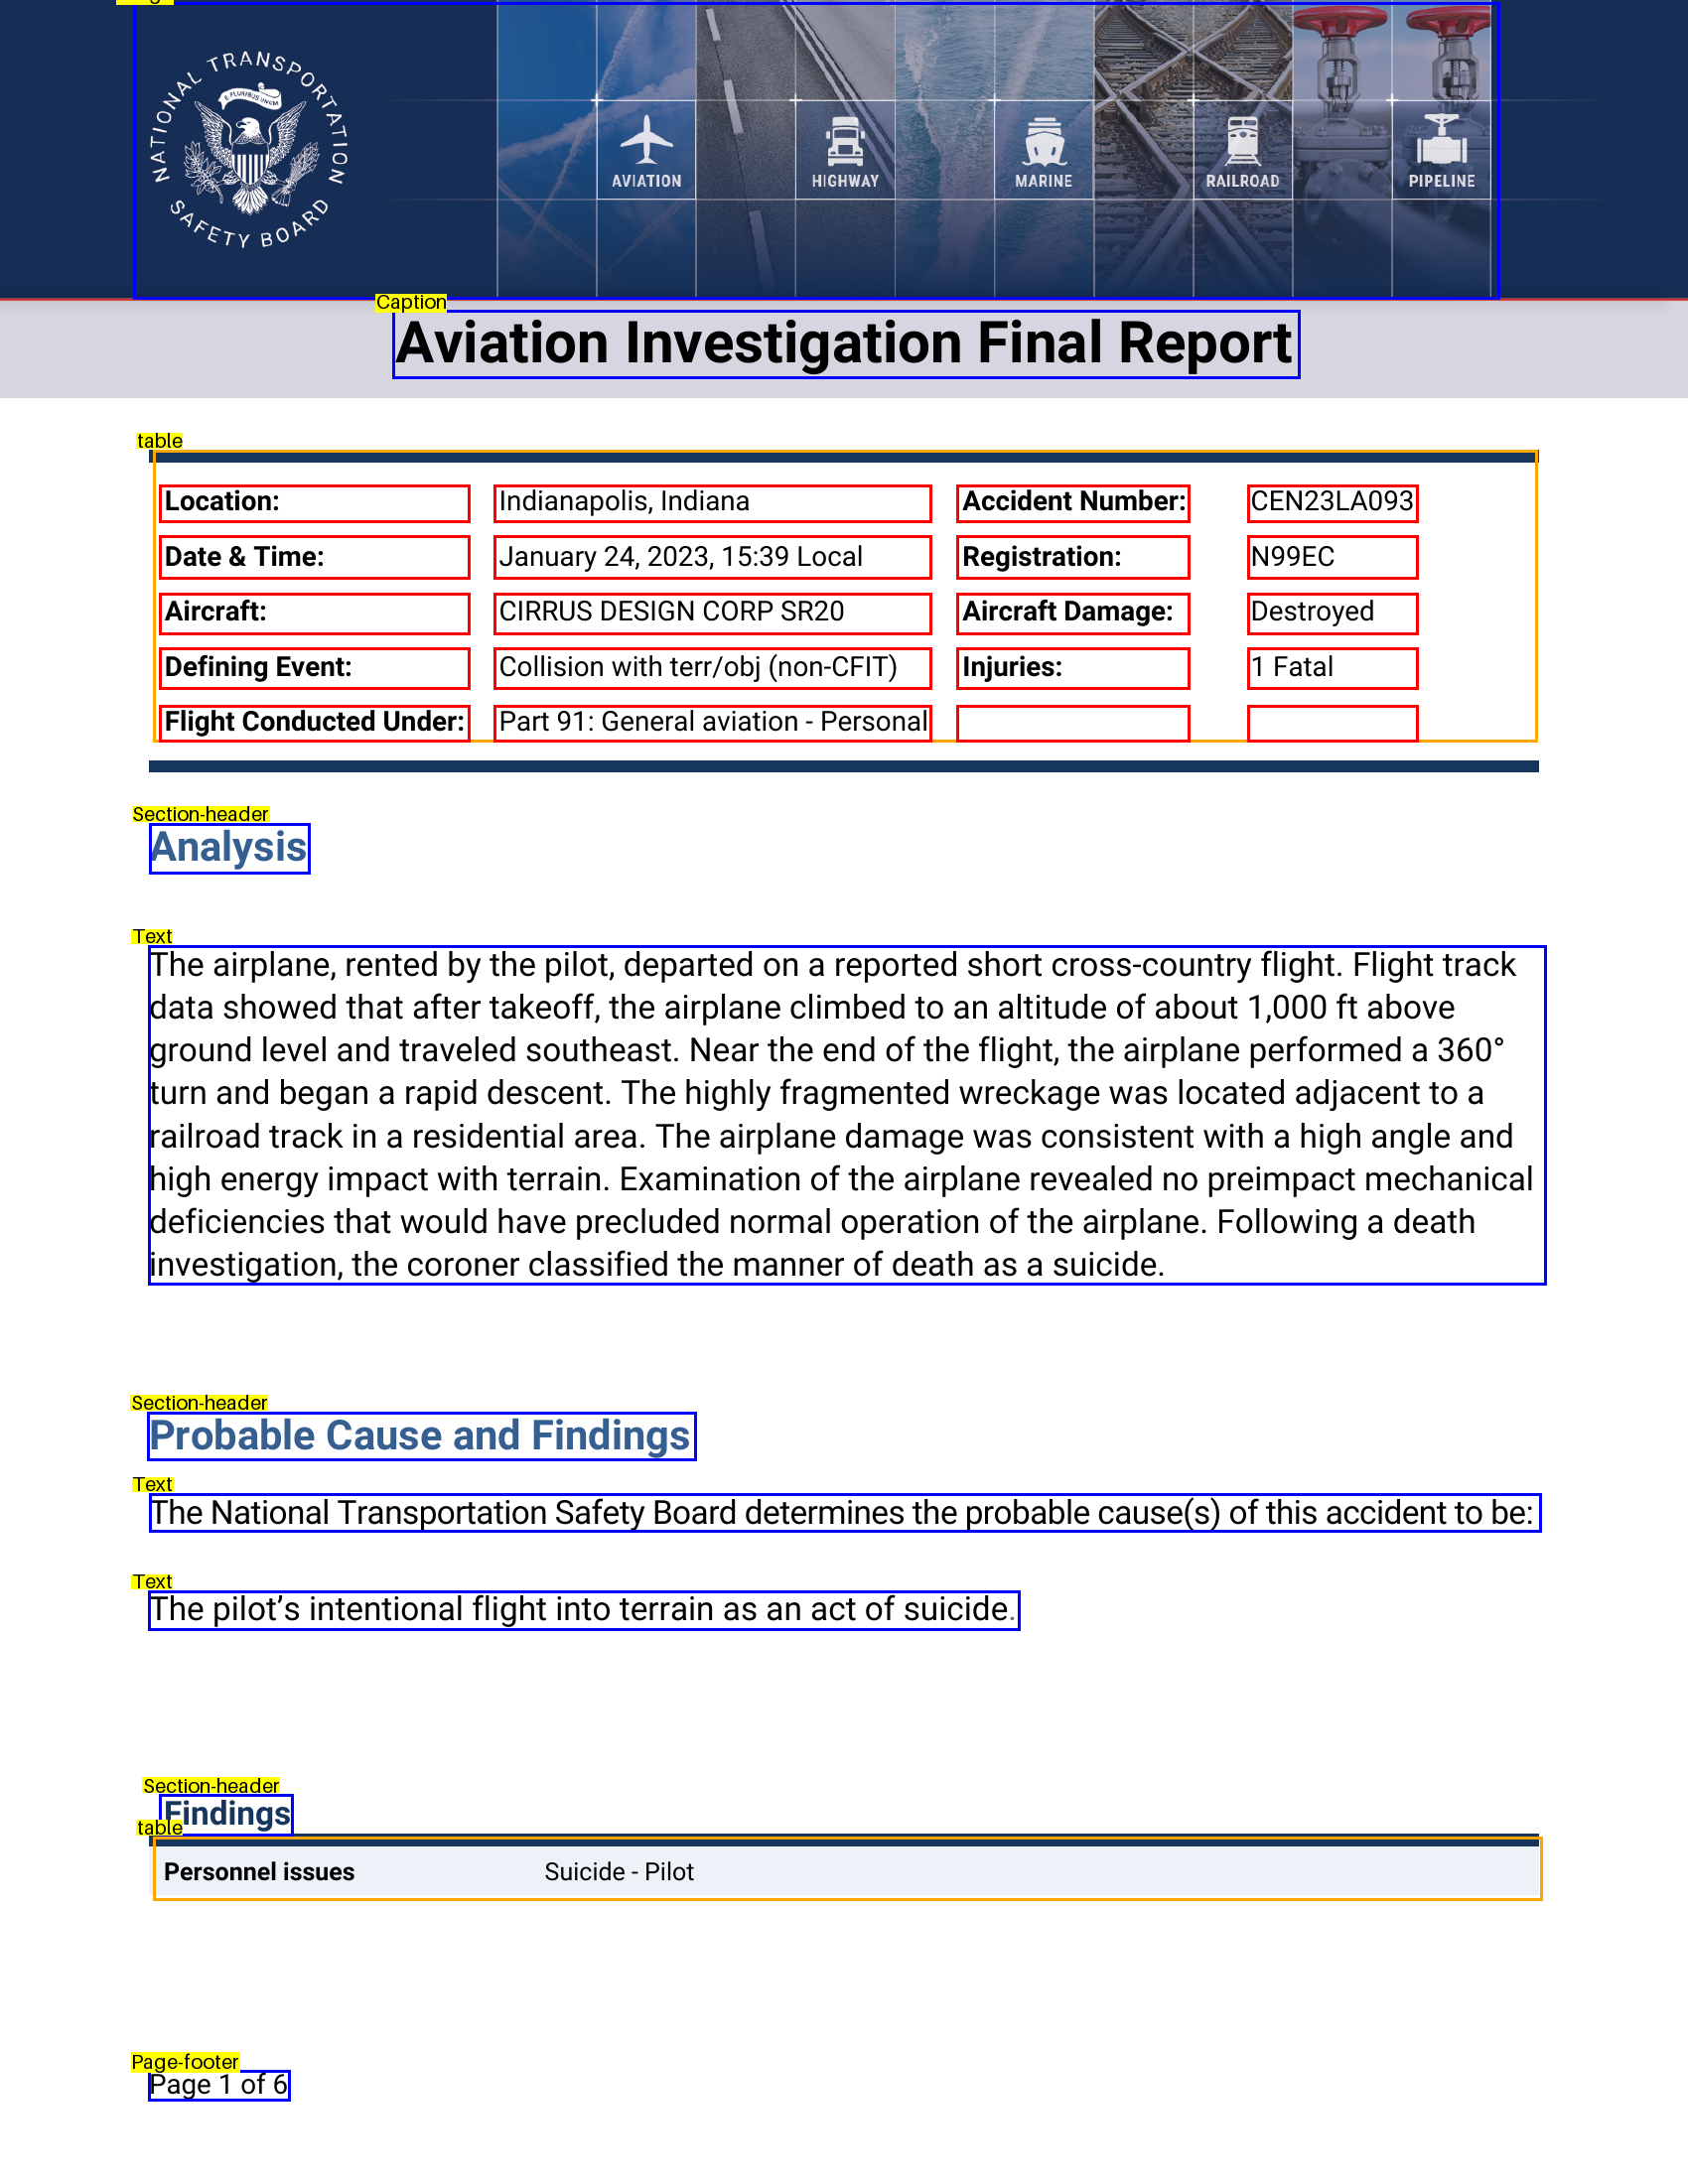

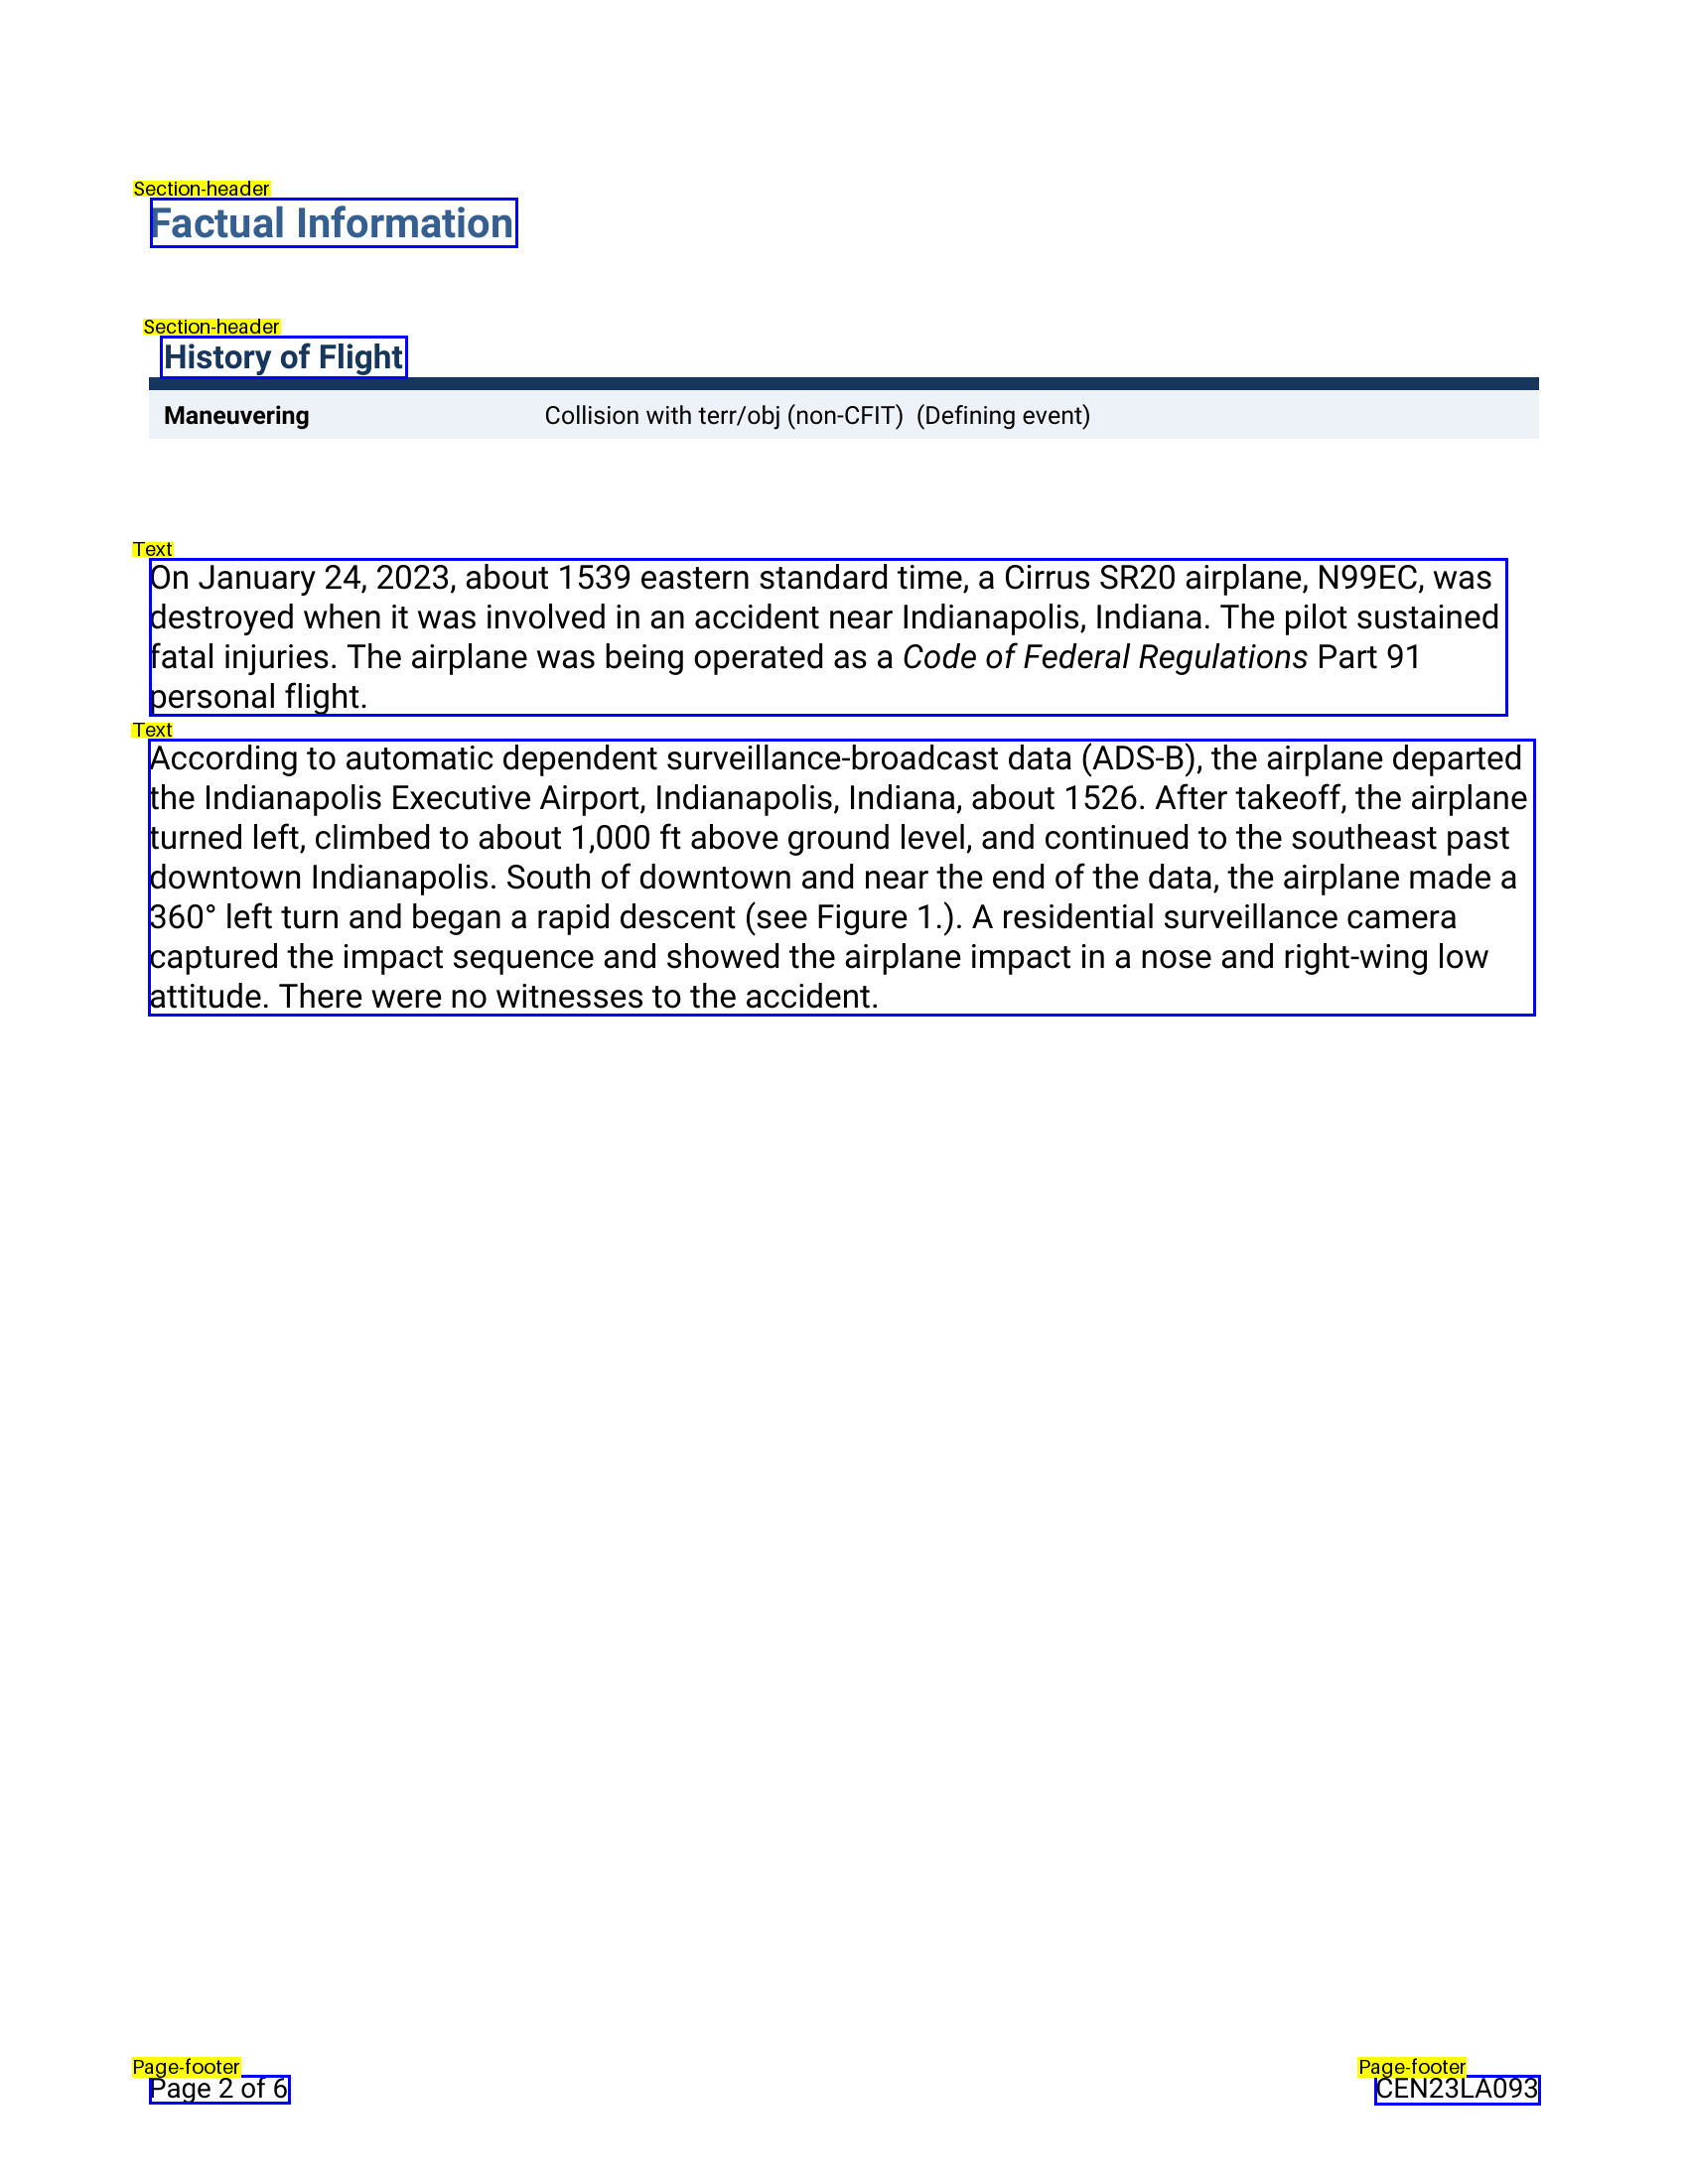

In [36]:
show_pages(docset)

### Show text representation of images and tables

### Parse table structure and extract properties as key value pairs

In [37]:
ds_extracted = (
    docset
    # Extract properties from tables and save it as key value pair in respective table elements
    .map( lambda doc: ExtractTableProperties.extract_table_properties( doc, property_name = "table_props", llm =llm)) 

    # Materialize document
    .materialize(
        path=f"{materialize_dir}/docset_extrTblprop",
        source_mode=MaterializeSourceMode.IF_PRESENT)
)

ds_extracted.show(limit=6)

2024-08-26 05:05:47,959	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-23_18-41-10_588373_17896/logs/ray-data
2024-08-26 05:05:47,959	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)->MapBatches(<lambda>)->MapBatches(materialize)]


- ReadBinary->SplitBlocks(3) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document)->MapBatches(<lambda>)->MapBatches(materialize) 2:   0%|                   …

Running 0:   0%|                                                                                              …

{'properties': {'path': 's3://aryn-public/ntsb/22.pdf',
                'filetype': 'application/pdf'},
 'elements': [{'type': 'Image',
               'bbox': [0.07889708575080423,
                        0.001083284616470337,
                        0.8883130600873161,
                        0.1371394070712003],
               'properties': {'score': 0.7501668930053711,
                              'image_size': [1396, 320],
                              'image_mode': 'RGB',
                              'image_format': None,
                              'page_number': 1,
                              'summary': {'is_graph': False,
                                          'summary': 'The image is a banner '
                                                     'from the National '
                                                     'Transportation Safety '
                                                     'Board (NTSB) featuring '
                                               

#### Sometime document level metadata is found in a table. 
Here we assign that metdata to the entire document

In [38]:
# we assign properties from 1st table element to document level 
ds_prop1 = ds_extracted.map( lambda doc : AssignDocProperties.assign_doc_properties( doc, element_type="table", property_name = "table_props"))
ds_prop1.show(limit=6, show_elements = False)

2024-08-26 05:06:02,919	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-23_18-41-10_588373_17896/logs/ray-data
2024-08-26 05:06:02,920	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)->MapBatches(<lambda>)]


- ReadBinary->SplitBlocks(2) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document)->MapBatches(<lambda>) 2:   0%|                                            …

Running 0:   0%|                                                                                              …

{'properties': {'path': 's3://aryn-public/ntsb/22.pdf',
                'filetype': 'application/pdf',
                'entity': {'location': 'Indianapolis, Indiana',
                           'accidentNumber': 'CEN23LA093',
                           'dateTime': 'January 24, 2023, 15.39 Local',
                           'registration': 'N9IEC',
                           'aircraft': 'CIRRUS DESIGN CORP SR2O',
                           'aircraftDamage': 'Destroyed',
                           'definingEvent': 'Collision with terr/obj '
                                            '(non-CFIT)',
                           'injuries': 'Fatal',
                           'flightConductedUnder': 'Part 91: General aviation '
                                                   'Personal'}},
 'elements': '<43 elements>',
 'lineage_id': '15fdc11d-0089-4a6b-9bd4-54917ed72da4',
 'doc_id': 'cfae4714-6368-11ef-a808-0affc3b35d89',
 'type': 'pdf',
 'binary_representation': b'<1419497 bytes>'}


###  Standardize data (location and date)

In [39]:
# We noramalize the date and location using LocationStandardizer and DateTimeStandardizer transform
loc_standardizer = LocationStandardizer()
date_standardizer = DateTimeStandardizer()

ds_normd = (
    ds_prop1
    # Converts state abbreviations to their full names.
    .map( lambda doc: loc_standardizer.standardize(doc, key_path = ["properties","entity","location"]))

    # Converts datetime into a common format
    .map( lambda doc: date_standardizer.standardize(doc, key_path = ["properties","entity","dateTime"]))

    # Materialize document
    .materialize(
        path=f"{materialize_dir}/docset_normalized",
        source_mode=MaterializeSourceMode.IF_PRESENT)
)
ds_normd.show(limit=6, show_elements = False)

2024-08-26 05:06:05,787	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-23_18-41-10_588373_17896/logs/ray-data
2024-08-26 05:06:05,788	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)->MapBatches(<lambda>)->MapBatches(<lambda>)->MapBatches(<lambda>)->MapBatches(materialize)]


- ReadBinary->SplitBlocks(2) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document)->MapBatches(<lambda>)->MapBatches(<lambda>)->MapBatches(<lambda>)->MapBatc…

Running 0:   0%|                                                                                              …

{'properties': {'path': 's3://aryn-public/ntsb/22.pdf',
                'filetype': 'application/pdf',
                'entity': {'location': 'Indianapolis, Indiana',
                           'accidentNumber': 'CEN23LA093',
                           'dateTime': 'January 24, 2023, 15:39 ',
                           'registration': 'N9IEC',
                           'aircraft': 'CIRRUS DESIGN CORP SR2O',
                           'aircraftDamage': 'Destroyed',
                           'definingEvent': 'Collision with terr/obj '
                                            '(non-CFIT)',
                           'injuries': 'Fatal',
                           'flightConductedUnder': 'Part 91: General aviation '
                                                   'Personal',
                           'day': datetime.date(2023, 1, 24)}},
 'elements': '<43 elements>',
 'lineage_id': 'e36ae9cf-b8be-4540-898e-9099a720ae16',
 'doc_id': 'cfae4714-6368-11ef-a808-0affc3b35d89',
 'type': 'p

In [40]:
# Show tables and their conversion to properties
display_page_and_table_properties(ds_normd.take_all())

2024-08-26 05:06:07,244	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-23_18-41-10_588373_17896/logs/ray-data
2024-08-26 05:06:07,244	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)]


- ReadBinary->SplitBlocks(2) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document) 2:   0%|                                                                  …

Running 0:   0%|                                                                                              …

Page props: 


{'location': 'Indianapolis, Indiana',
 'accidentNumber': 'CEN23LA093',
 'dateTime': 'January 24, 2023, 15:39 ',
 'registration': 'N9IEC',
 'aircraft': 'CIRRUS DESIGN CORP SR2O',
 'aircraftDamage': 'Destroyed',
 'definingEvent': 'Collision with terr/obj (non-CFIT)',
 'injuries': 'Fatal',
 'flightConductedUnder': 'Part 91: General aviation Personal',
 'day': datetime.date(2023, 1, 24)}


Element Type:  table
Element Properties:  {
  "score": 0.6029046177864075,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 1,
  "keyValueTable": "True",
  "table_props": {
    "location": "Indianapolis, Indiana",
    "accidentNumber": "CEN23LA093",
    "dateTime": "January 24, 2023, 15:39 ",
    "registration": "N9IEC",
    "aircraft": "CIRRUS DESIGN CORP SR2O",
    "aircraftDamage": "Destroyed",
    "definingEvent": "Collision with terr/obj (non-CFIT)",
    "injuries": "Fatal",
    "flightConductedUnder": "Part 91: General aviation Personal",
    "day": "2023-01-24"
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.4644432067871094,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 1
}


<IPython.core.display.HTML object>

Element Type:  table
Element Properties:  {
  "score": 0.8807757496833801,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 4,
  "keyValueTable": "True",
  "table_props": {
    "certificate": "Private",
    "age": "20",
    "gender": "Male",
    "airplaneRatings": "Single-engine land",
    "seatOccupied": "Left",
    "otherAircraftRatings": "None",
    "restraintUsed": "4-point",
    "instrumentRatings": "Airplane",
    "secondPilotPresent": "No",
    "instructorRatings": "None",
    "toxicologyPerformed": "Yes",
    "medicalCertification": "Class Without waivers/limitations",
    "lastFaaMedicalExam": "March 12,2020",
    "occupationalPilot": "No",
    "lastFlightReviewOrEquivalent": "",
    "flightTimeEstimatedInHours": 219.5,
    "flightTimeTotalInHours": 197.5,
    "flightTimePilotInCommandInHours": 32.8
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.8686211705207825,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 4,
  "keyValueTable": "True",
  "table_props": {
    "aircraftMake": "CIRRUS DESIGN CORP",
    "registration": "N9IEC",
    "modelSeries": "SR2O",
    "aircraftCategory": "Airplane",
    "yearOfManufacture": 2016,
    "airworthinessCertificate": "Normal",
    "serialNumber": "2307",
    "landingGearType": "Tricycle",
    "dateTypeOfLastInspection": "November 21,2022 100 hour",
    "certifiedMaxGrossWtInIbs": 3050,
    "airframeTotalTimeInHrs": 2532.7,
    "engineManufacturer": "CONT MOTOR",
    "engineModelSeries": "10-360-ES 26B",
    "ratedPowerInHorsepower": 210
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.872930645942688,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 5,
  "keyValueTable": "True",
  "table_props": {
    "conditionsAtAccidentSite": "Visual (VMC)",
    "conditionOfLight": "Day",
    "observationFacilityElevationFtMsl": 792,
    "distanceFromAccidentSiteInNauticalMiles": 7,
    "observationTime": "20.54 Local",
    "directionFromAccidentSite": 282,
    "lowestCloudCondition": "Few 3000 ft AGL",
    "visibilityInMiles": 10,
    "lowestCeiling": "Overcast 25000 ft AGL",
    "windSpeedInKnots": 3,
    "windDirection": 2305,
    "altimeterSettingInInchesHg": 30.14,
    "temperatureInC": 6,
    "dewPointInC": -2,
    "precipitationAndObscuration": "No Obscuration; No Precipitation",
    "departurePoint": "Indianapolis, IN",
    "destination": "Indianapolis, IN",
    "typeOfClearance": "None",
    "typeOfAirspace": "Class D"
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.8112429976463318,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 5,
  "keyValueTable": "True",
  "table_props": {
    "crewInjuries": "Fatal",
    "aircraftDamage": "Destroyed",
    "passengerInjuries": "",
    "aircraftFire": "None",
    "groundInjuries": "",
    "aircraftExplosion": "None",
    "totalInjuries": "Fatal",
    "latitudeLongitude": "39.701295,-86.136893(est)"
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.793097734451294,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 6,
  "keyValueTable": "True",
  "table_props": {
    "investigatorInCharge": "Sauer; Aaron",
    "additionalParticipatingPersons": [
      "Christopher Johnson; FAA; Indianapolis, IN",
      "Brad Miller; Cirrus Aircraft; Duluth; MN"
    ],
    "originalPublishDate": "April 27,2023",
    "investigationClass": "Class 4",
    "note": "The NTSB did not travel to the scene of this accident",
    "investigationDocket": "https [Idata ntsbgov[Docket?ProjectIDz106630"
  }
}


In [41]:
## if removed, remove json import up top
from IPython.display import display, HTML
for e in ds_normd.take_all()[0].elements:
    if "table" in e.type:
        print("Element Type: ", e.type)
        print("Element Properties: ", json.dumps(e.properties, indent=2, default=str))
        display(HTML(e.table.to_html()))

2024-08-26 05:06:08,649	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-23_18-41-10_588373_17896/logs/ray-data
2024-08-26 05:06:08,650	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)]


- ReadBinary->SplitBlocks(2) 1:   0%|                                                                         …

- Map(Materialize._ray_to_document) 2:   0%|                                                                  …

Running 0:   0%|                                                                                              …

Element Type:  table
Element Properties:  {
  "score": 0.6029046177864075,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 1,
  "keyValueTable": "True",
  "table_props": {
    "location": "Indianapolis, Indiana",
    "accidentNumber": "CEN23LA093",
    "dateTime": "January 24, 2023, 15:39 ",
    "registration": "N9IEC",
    "aircraft": "CIRRUS DESIGN CORP SR2O",
    "aircraftDamage": "Destroyed",
    "definingEvent": "Collision with terr/obj (non-CFIT)",
    "injuries": "Fatal",
    "flightConductedUnder": "Part 91: General aviation Personal",
    "day": "2023-01-24"
  }
}


Element Type:  table
Element Properties:  {
  "score": 0.4644432067871094,
  "title": null,
  "columns": null,
  "rows": null,
  "page_number": 1
}


AttributeError: 'NoneType' object has no attribute 'to_html'

## Indexing the documents for retrieval

Now that we have extracted the text, partitioned it, labeled the partitions, extracted information and standardized it, we're ready to store it for retrieval

In [42]:
import os
if os.path.exists("/.dockerenv"):
    opensearch_host = "opensearch"
    print("Assuming we are in a Sycamore Jupyter container, using opensearch for OpenSearch host")
else:
    opensearch_host = "localhost"
    print("Assuming we are running outside of a container, using localhost for OpenSearch host")

index = "ntsb-demo-22"
os_client_args = {
    "hosts": [{"host": "localhost", "port": 9200}],
    "http_compress": True,
    "http_auth": ("admin", "admin"),
    "use_ssl": True,
    "verify_certs": False,
    "ssl_assert_hostname": False,
    "ssl_show_warn": False,
    "timeout": 120,
}

index_settings = {
    "body": {
        "settings": {
            "index.knn": True,
            "number_of_shards": 5,
            "number_of_replicas": 1
        },
        "mappings": {
            "properties": {
                "embedding": {
                  "dimension": 384,
                  "method": {
                    "engine": "faiss",
                    "space_type": "l2",
                    "name": "hnsw",
                    "parameters": {}
                  },
                  "type": "knn_vector"
                }
            }
        }
    }
}

Assuming we are running outside of a container, using localhost for OpenSearch host


### Creating embeddings

In [14]:
from sycamore.transforms.embed import SentenceTransformerEmbedder

embedded_docset = (
    ds_normd
    .spread_properties(["entity", "path"])
    .explode()
    .embed(embedder=SentenceTransformerEmbedder(batch_size=100, model_name="sentence-transformers/all-MiniLM-L6-v2"))
    .materialize(
        path=f"{materialize_dir}/docset_embed",
        source_mode=MaterializeSourceMode.IF_PRESENT)

)
embedded_docset.show()

2024-08-23 18:42:22,220	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-08-23 18:42:22,227	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-23_18-41-10_588373_17896/logs/ray-data
2024-08-23 18:42:22,227	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)->MapBatches(spread_properties)->MapBatches(explode)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable__SentenceTransformerEmbedder)] -> TaskPoolMapOperator[MapBatches(materialize)]


- ReadBinary->SplitBlocks(2) 1:   0%|                                                   | 0/7 [00:00<?, ?it/s]

- Map(Materialize._ray_to_document)->MapBatches(spread_properties)->MapBatches(explode) 2:   0%| | 0/7 [00:00<

- MapBatches(BaseMapTransformCallable__SentenceTransformerEmbedder) 3:   0%|            | 0/7 [00:00<?, ?it/s]

- MapBatches(materialize) 4:   0%|                                                      | 0/7 [00:00<?, ?it/s]

Running 0:   0%|                                                                        | 0/7 [00:00<?, ?it/s]

{'properties': {'path': 's3://aryn-public/ntsb/22.pdf',
                'filetype': 'application/pdf',
                'entity': {'location': 'Indianapolis, Indiana',
                           'accidentNumber': 'CEN23LA093',
                           'dateTime': 'January 24, 2023, 15:39 ',
                           'registration': 'N9IEC',
                           'aircraft': 'CIRRUS DESIGN CORP SR2O',
                           'aircraftDamage': 'Destroyed',
                           'definingEvent': 'Collision with terr/obj '
                                            '(non-CFIT)',
                           'injuries': 'Fatal',
                           'flightConductedUnder': 'Part 91: General aviation '
                                                   'Personal',
                           'day': datetime.date(2023, 1, 24)}},
 'elements': [],
 'lineage_id': 'fcb576d8-c1b9-4bca-a936-c6e2787d1aed',
 'doc_id': '5ae1e75c-60f1-11ef-8575-0affc3b35d89',
 'type': 'pdf',
 'binary

### Write the OpenSearch index

In [15]:
embedded_docset.write.opensearch(
    os_client_args=os_client_args,
    index_name=index,
    index_settings=index_settings,
)

2024-08-23 18:43:30,729	WARNING util.py:560 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-08-23 18:43:30,738	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-08-23_18-41-10_588373_17896/logs/ray-data
2024-08-23 18:43:30,739	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadBinary] -> TaskPoolMapOperator[Map(Materialize._ray_to_document)->MapBatches(spread_properties)->MapBatches(explode)] -> ActorPoolMapOperator[MapBatches(BaseMapTransformCallable__SentenceTransformerEmbedder)] -> TaskPoolMapOperator[MapBatches(materialize)->MapBatches(OsrchWrite)]


- ReadBinary->SplitBlocks(2) 1:   0%|                                                   | 0/7 [00:00<?, ?it/s]

- Map(Materialize._ray_to_document)->MapBatches(spread_properties)->MapBatches(explode) 2:   0%| | 0/7 [00:00<

- MapBatches(BaseMapTransformCallable__SentenceTransformerEmbedder) 3:   0%|            | 0/7 [00:00<?, ?it/s]

- MapBatches(materialize)->MapBatches(OsrchWrite) 4:   0%|                              | 0/7 [00:00<?, ?it/s]

Running 0:   0%|                                                                        | 0/7 [00:00<?, ?it/s]

I0000 00:00:1724438616.951941   17896 config.cc:230] gRPC experiments enabled: call_status_override_on_cancellation, event_engine_dns, event_engine_listener, http2_stats_fix, monitoring_experiment, pick_first_new, trace_record_callops, work_serializer_clears_time_cache


## Answer some questions

### Create a connection to OpenSearch

In [16]:
from sycamore.transforms.query import OpenSearchQueryExecutor
from sycamore.data import OpenSearchQuery
from opensearchpy import OpenSearch

os_client_args = {
    "hosts": [{"host": "localhost", "port": 9200}],
    "http_compress": True,
    "http_auth": ('admin', 'admin'),
    "use_ssl": True,
    "verify_certs": False,
    "ssl_assert_hostname": False,
    "ssl_show_warn": False,
    "timeout": 120
    
}


client = OpenSearch(**os_client_args)

osq = OpenSearchQueryExecutor(os_client_args)

### Question

In [17]:
question = "Were there any incidents involving Cirrus airplanes"

### Text query

In [18]:
query = OpenSearchQuery()
query["index"] = index
query["query"] = {
    "_source": {"excludes": ["embedding"]},
    "query": {"match": {"text_representation": question}},
    "size": 20
}
result = osq.query(query)["result"]

In [19]:
result

{'took': 17,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 8, 'relation': 'eq'},
  'max_score': 1.8845887,
  'hits': [{'_index': 'ntsb-demo-22',
    '_id': 'ee1f9cf6-b92e-4526-becb-a68ee4a9bdd3',
    '_score': 1.8845887,
    '_source': {'parent_id': '5ae1e75c-60f1-11ef-8575-0affc3b35d89',
     'elements': [],
     'bbox': [0.08683842378504136,
      0.3388180264559659,
      0.913018798828125,
      0.46512223677201703],
     'shingles': None,
     'text_representation': 'According to automatic dependent surveillance-broadcast data (ADS-B), the airplane departed\nthe Indianapolis Executive Airport, Indianapolis, Indiana, about 1526. After takeoff, the airplane\nturned left, climbed to about 1,000 ft above ground level, and continued to the southeast past\ndowntown Indianapolis. South of downtown and near the end of the data, the airplane made a\n360° left turn and began a rapid descent (see Figure 1.). A resident

### RAG query

In [20]:
# get the embedding model ID 
import requests
def get_model_id():
    query = {
        'query': {
            'bool': {
                'must': [
                    {
                        'match': {'name': 'all-MiniLM-L6-v2'},
                    },
                    {
                        'term': {'model_config.model_type': 'bert'},
                    },
                ],
            },
        },
    }
    with requests.get(f'https://{opensearch_host}:9200/_plugins/_ml/models/_search', json=query, verify=False) as resp:
        res = json.loads(resp.text)
        return res['hits']['hits'][0]['_id']

In [21]:
# RAG config
embedding_model_id = get_model_id()
search_pipeline = "hybrid_rag_pipeline"
llm = "gpt-4o"

rag_query = OpenSearchQuery()
rag_query["index"] = index

# hybrid searc
rag_query["query"] = {
    "_source": {"excludes": ["embedding"]},
    "query": {
        "hybrid": {
            "queries": [
                {"match": {"text_representation": question}},
                {
                    "neural": {
                        "embedding": {
                            "query_text": question,
                            "model_id": embedding_model_id,
                            "k": 100,
                        }
                    }
                },
            ]
        }
    },
    "size": 20
}

# RAG params
rag_query["params"] = {"search_pipeline": search_pipeline}
rag_query["query"]["ext"] = {
    "generative_qa_parameters": {
        "llm_question": question,
        "context_size": 10,
        "llm_model": llm,
    }
}
rag_result = osq.query(rag_query)["result"]

In [22]:
rag_result["ext"]["retrieval_augmented_generation"]["answer"]

'Yes, there was an incident involving a Cirrus SR20 airplane (N99EC) on January 24, 2023, near Indianapolis, Indiana. The airplane was destroyed, and the pilot sustained fatal injuries. The accident occurred during a personal flight under Part 91 of the Federal Regulations. The airplane departed from Indianapolis Executive Airport, climbed to about 1,000 ft, and then made a 360° turn before descending rapidly and crashing. The wreckage was found near a railroad track in a residential area. The investigation revealed no mechanical malfunctions, and the coroner classified the manner of death as a suicide [1][2][6][7][8][10].'

In [23]:
## can remove
rag_result

{'took': 5,
 'timed_out': False,
 'terminated_early': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 20, 'relation': 'eq'},
  'max_score': 0.9279047,
  'hits': [{'_index': 'ntsb-demo-22',
    '_id': '1d727c86-eff5-478f-9de3-ec2a996d4d5b',
    '_score': 0.9279047,
    '_source': {'parent_id': '5ae1e75c-60f1-11ef-8575-0affc3b35d89',
     'elements': [],
     'bbox': [0.08808669146369486,
      0.2560101318359375,
      0.8966921817555147,
      0.3282737315784801],
     'shingles': None,
     'text_representation': 'On January 24, 2023, about 1539 eastern standard time, a Cirrus SR20 airplane, N99EC, was\ndestroyed when it was involved in an accident near Indianapolis, Indiana. The pilot sustained\nfatal injuries. The airplane was being operated as a Code of Federal Regulations Part 91\npersonal flight.\n',
     'type': 'Text',
     'doc_id': '1d727c86-eff5-478f-9de3-ec2a996d4d5b',
     'properties': {'score': 0.7250540256500244,

### Filtered RAG query

In [24]:
filtered_rag_query = OpenSearchQuery()
filtered_rag_query["index"] = index
question = "Were there any airplace incidents in Indiana on January 24, 2023?"
filter = {
    "bool": {
        "must": [
          {
            "match_phrase": {
              "properties.entity.location": "Indiana"
            }
          }
          
        ]
    }
}

# hybrid search
filtered_rag_query["query"] = {
    "_source": {"excludes": ["embedding"]},
    "query": {
        "hybrid": {
            "queries": [
                {
                  "bool": {
                      "must": [
                          {
                              "match": {
                                  "text_representation": question
                              }
                          }
                      ],
                      "filter": filter
                  }
                },
                {
                    "neural": {
                        "embedding": {
                            "query_text": question,
                            "model_id": embedding_model_id,
                            "k": 100,
                            "filter": filter
                        }
                    }
                },
            ]
        }
    },
    "size": 20
}

# RAG params
filtered_rag_query["params"] = {"search_pipeline": search_pipeline}

filtered_rag_query["query"]["ext"] = {
    "generative_qa_parameters": {
        "llm_question": question,
        "context_size": 10,
        "llm_model": llm,
    }
}

In [25]:
filtered_rag_result = osq.query(filtered_rag_query)["result"]

In [26]:
filtered_rag_result["ext"]["retrieval_augmented_generation"]["answer"]

'Yes, there was an airplane incident in Indiana on January 24, 2023. A Cirrus SR20 airplane, registration N99EC, was destroyed in an accident near Indianapolis. The pilot sustained fatal injuries, and the accident was classified as a collision with terrain or objects (non-CFIT) under Part 91 general aviation personal flight regulations [1][2]. The cause of death was determined to be blunt force trauma, and the manner of death was ruled as suicide [7].'